# Q3
Predict the likelihood of delay for the list of shipments in “New_bookings.csv” dataset.

# 1. Library Import

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import matplotlib.pyplot as plt
import helper

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from scipy.stats import chi2_contingency
from scipy.stats import uniform, randint

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report


from datetime import datetime
from datetime import timedelta

# 2. Data Loading

In [2]:
df_GPS = pd.read_csv('Data/GPS_data.csv')
df_bookings = pd.read_csv('Data/Shipment_bookings.csv')
df_new_bookings = pd.read_csv('Data/New_bookings.csv')
print(df_bookings.shape, df_new_bookings.shape, df_GPS.shape)

(3245, 15) (1000, 15) (641662, 4)


In [3]:
df = pd.read_csv('Data/bookings_processed.csv')

In [4]:
df_train = df.copy()

# 3. Date Formatting

In [5]:
# convert time strings to date_time

# convert to datetime format 
date_cols = ['FIRST_COLLECTION_SCHEDULE_EARLIEST', 
             'FIRST_COLLECTION_SCHEDULE_LATEST', 
             'LAST_DELIVERY_SCHEDULE_EARLIEST',
            'LAST_DELIVERY_SCHEDULE_LATEST']

for data in [df_new_bookings, df_train]:
    for i in date_cols:
        data[i]=pd.to_datetime(data[i])

# 4. Preliminary EDA

In [6]:
df_new_bookings['VEHICLE_SIZE'].value_counts()

VEHICLE_SIZE
Tractor Unit    806
3.5T Van        161
3.5 T Van        17
18T Rigid         7
7.5T Rigid        5
7.5 T             4
Name: count, dtype: int64

In [7]:
df_train['VEHICLE_SIZE'].value_counts()

VEHICLE_SIZE
Tractor Unit    2607
3.5T Van         536
3.5 T Van         63
18T Rigid         20
7.5T Rigid        11
26T Rigid          4
Name: count, dtype: int64

In [8]:
df_new_bookings['VEHICLE_BUILD_UP'].value_counts()

VEHICLE_BUILD_UP
Curtain-Side 13.6M Trailer    667
Box                           140
LWB Van                        83
Box 44ft                       52
Temperature-Controlled         29
Tractor Only 6x2                9
Curtain Side                    9
Mega / High Cube Trailer        6
High Security                   3
Luton Tail Lift                 2
Name: count, dtype: int64

In [9]:
df_train['VEHICLE_BUILD_UP'].value_counts()

VEHICLE_BUILD_UP
Curtain-Side 13.6M Trailer    1773
Box 44ft                       472
Box                            415
LWB Van                        367
Curtain Side                    78
Tractor Only                    45
Tractor Only 6x2                39
Temperature-Controlled          31
40ft Container                  14
Double Deck Trailer              4
High Security                    1
Box 40ft                         1
20ft Container                   1
Name: count, dtype: int64

In [10]:
df_test = df_new_bookings.copy()

# 5. Feature Engineering

In [11]:
# calculate the difference between collection & delivery lats & lons

datasets = [df_train, df_test]


for data in datasets:
    
    # calculate durations between collection & delivery
    d1 = data['FIRST_COLLECTION_SCHEDULE_EARLIEST'] 
    d2 = data['LAST_DELIVERY_SCHEDULE_EARLIEST']
    d3 = data['FIRST_COLLECTION_SCHEDULE_LATEST']
    d4 = data['LAST_DELIVERY_SCHEDULE_LATEST']
    # calculate durations between collection & delivery
    d1 = data['FIRST_COLLECTION_SCHEDULE_EARLIEST'] 
    d2 = data['LAST_DELIVERY_SCHEDULE_EARLIEST']
    d3 = data['FIRST_COLLECTION_SCHEDULE_LATEST']
    d4 = data['LAST_DELIVERY_SCHEDULE_LATEST']

    data['duration1']=(d2-d1).dt.total_seconds()
    data['duration2']=(d4-d3).dt.total_seconds()
    data['duration_longest']=(d4-d1).dt.total_seconds()

    data['collection_window'] = (data['FIRST_COLLECTION_SCHEDULE_LATEST'] - data['FIRST_COLLECTION_SCHEDULE_EARLIEST']).dt.total_seconds()
    data['delivery_window'] = (data['LAST_DELIVERY_SCHEDULE_LATEST'] - data['LAST_DELIVERY_SCHEDULE_EARLIEST']).dt.total_seconds()
    
    data['lat_diff']=abs(data['LAST_DELIVERY_LATITUDE'] - data['FIRST_COLLECTION_LATITUDE']) # latitude difference
    data['lon_diff'] = abs(data['LAST_DELIVERY_LONGITUDE'] - data['FIRST_COLLECTION_LONGITUDE']) # longitude difference
    
     # use outward code from postcode for less granularity
    data['FIRST_COLLECTION_OUTWARD_CODE'] = data['FIRST_COLLECTION_POST_CODE'].str.split(' ', n=1, expand=True)[0]
    data['LAST_DELIVERY_OUTWARD_CODE'] = data['LAST_DELIVERY_POST_CODE'].str.split(' ', n=1, expand=True)[0]

# 6. Feature Processing

In [12]:
# define predictors
not_predictors = ['SHIPMENT_NUMBER',
                  'PROJECT_ID', 
                  'CARRIER_DISPLAY_ID',
                  'RECORD_TIMESTAMP',
                  'LAT', 
                  'LON', 
                  'POSTCODE',
                  'almost_on_time',
                  'on_time',
                  'GPS_coord',
                  'last_delivery_coord',
                  'FIRST_COLLECTION_SCHEDULE_EARLIEST',
                  'FIRST_COLLECTION_SCHEDULE_LATEST',
                  'LAST_DELIVERY_SCHEDULE_EARLIEST',
                  'LAST_DELIVERY_SCHEDULE_LATEST',
                  'almost_reached_delivery_loc',
                  'reached_delivery_loc',
                  'FIRST_COLLECTION_POST_CODE',
                  'LAST_DELIVERY_POST_CODE'
                  
                 ]
predictors = np.setdiff1d(df.columns, not_predictors)
# add new features to list of predictors
predictors=list(predictors)
predictors.extend(['lat_diff', 
                   'lon_diff', 
                   'duration1', 
                   'duration2', 
                   'duration_longest', 
                   'collection_window', 
                   'delivery_window', 
                   'FIRST_COLLECTION_OUTWARD_CODE', 
                   'LAST_DELIVERY_OUTWARD_CODE'])
predictors

['FIRST_COLLECTION_LATITUDE',
 'FIRST_COLLECTION_LONGITUDE',
 'LAST_DELIVERY_LATITUDE',
 'LAST_DELIVERY_LONGITUDE',
 'VEHICLE_BUILD_UP',
 'VEHICLE_SIZE',
 'lat_diff',
 'lon_diff',
 'duration1',
 'duration2',
 'duration_longest',
 'collection_window',
 'delivery_window',
 'FIRST_COLLECTION_OUTWARD_CODE',
 'LAST_DELIVERY_OUTWARD_CODE']

In [13]:
# define target variable
target = 'almost_on_time'

# 7. EDA

In [14]:
df = df_train.copy()

In [15]:
# separate categorical & numerical features

num_feats = ['FIRST_COLLECTION_LATITUDE',
 'FIRST_COLLECTION_LONGITUDE',
 'LAST_DELIVERY_LATITUDE',
 'LAST_DELIVERY_LONGITUDE',
 'duration1',
 'duration2',
 'duration_longest',
 'lat_diff',
 'lon_diff',
 'collection_window', 
 'delivery_window'
            ]

cat_feats = ['VEHICLE_BUILD_UP', 'VEHICLE_SIZE', 'FIRST_COLLECTION_OUTWARD_CODE', 'LAST_DELIVERY_OUTWARD_CODE']

## 7.1 Summary Statistics

In [16]:
df.describe()

,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,LAT,LON,reached_delivery_loc,almost_reached_delivery_loc,on_time,almost_on_time,duration1,duration2,duration_longest,collection_window,delivery_window,lat_diff,lon_diff
count,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3.241000e+03,3.241000e+03,3.241000e+03,3241.000000,3241.000000,3241.000000,3241.000000
mean,53.001403,-1.581784,52.466228,-1.511250,52.567441,-1.459611,0.152731,0.180500,0.116939,0.136995,5.062539e+04,4.602746e+04,5.554291e+04,9515.452638,4917.518976,1.338046,1.349868
std,0.854842,0.879126,1.100215,1.569749,1.673430,1.331902,0.359783,0.384663,0.321397,0.343895,8.566982e+04,8.127741e+04,8.650098e+04,29649.109951,15072.350831,0.852482,1.237820
min,50.386450,-6.104285,50.228709,-8.687242,0.000000,-8.672518,0.000000,0.000000,0.000000,0.000000,-6.300000e+04,-6.480000e+04,-6.120000e+04,-3840.000000,0.000000,0.000000,0.000000
25%,52.322617,-2.120660,51.557511,-1.983264,51.618118,-1.885023,0.000000,0.000000,0.000000,0.000000,1.512000e+04,1.440000e+04,1.800000e+04,1800.000000,1800.000000,0.716249,0.507333
50%,53.304842,-1.630808,52.371658,-1.231993,52.602612,-1.291154,0.000000,0.000000,0.000000,0.000000,2.340000e+04,2.340000e+04,2.700000e+04,3600.000000,1800.000000,1.291850,1.104604
75%,53.634051,-1.074008,53.207122,-0.515011,53.295114,-0.737649,0.000000,0.000000,0.000000,0.000000,6.294000e+04,5.580000e+04,6.630000e+04,4140.000000,3600.000000,1.982090,1.600511
max,55.932081,1.397815,57.653603,1.457581,57.467761,1.402415,1.000000,1.000000,1.000000,1.000000,2.851200e+06,2.851200e+06,2.851200e+06,507600.000000,360240.000000,4.731393,7.613234


In [17]:
num_feats

['FIRST_COLLECTION_LATITUDE',
 'FIRST_COLLECTION_LONGITUDE',
 'LAST_DELIVERY_LATITUDE',
 'LAST_DELIVERY_LONGITUDE',
 'duration1',
 'duration2',
 'duration_longest',
 'lat_diff',
 'lon_diff',
 'collection_window',
 'delivery_window']

In [18]:
target_corr_feats = ['FIRST_COLLECTION_LATITUDE',
 'FIRST_COLLECTION_LONGITUDE',
 'LAST_DELIVERY_LATITUDE',
 'LAST_DELIVERY_LONGITUDE',
 'duration1',
 'duration2',
 'duration_longest',
 'lat_diff',
 'lon_diff',
 'collection_window',
 'delivery_window', 
  'almost_on_time'
]

## 7.2 Correlation Matrix

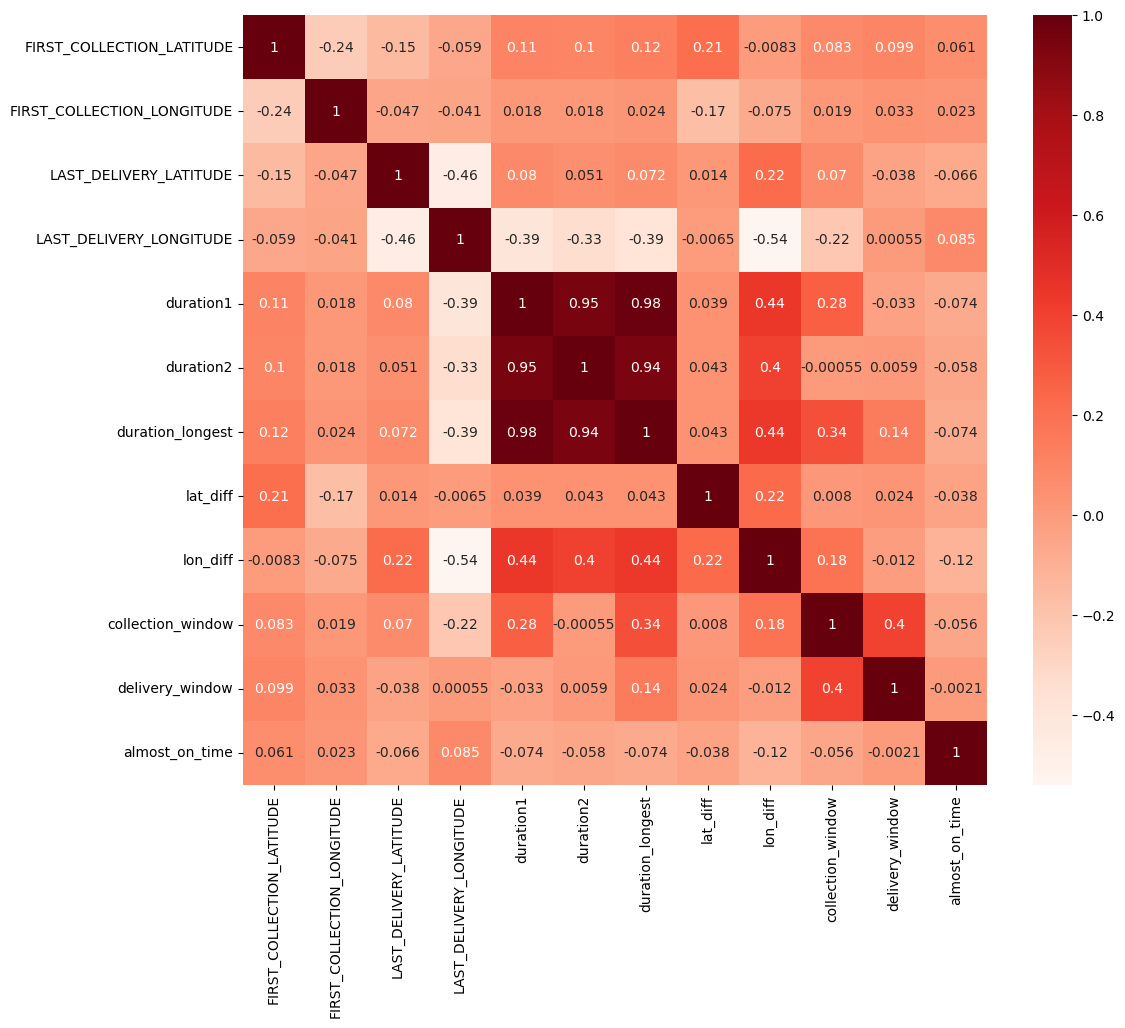

In [19]:
%matplotlib inline

# num_feats.append('almost_on_time') # added temporarily to get correlation matrix & target correlation

plt.figure(figsize=(12,10))
cor = df[target_corr_feats].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

__Findings__
* duration1, duration2 & duration_longest are highly correlated so we need to choose one of them

### 7.3 Target Correlation

In [20]:
# find correlation with target variable
corr_almost_on_time=cor['almost_on_time'].sort_values(ascending=False)
print(abs(corr_almost_on_time))

almost_on_time                1.000000
LAST_DELIVERY_LONGITUDE       0.085094
FIRST_COLLECTION_LATITUDE     0.061112
FIRST_COLLECTION_LONGITUDE    0.022891
delivery_window               0.002078
lat_diff                      0.037972
collection_window             0.055758
duration2                     0.058115
LAST_DELIVERY_LATITUDE        0.066439
duration_longest              0.073718
duration1                     0.074067
lon_diff                      0.116044
Name: almost_on_time, dtype: float64


__Findings__

* lon_diff has the highest correlation with target variable but overall, the correlations are low across all columns
* Out of the 3 durations, duration2 has the highest target variable correlation

## 7.4 Information Gain

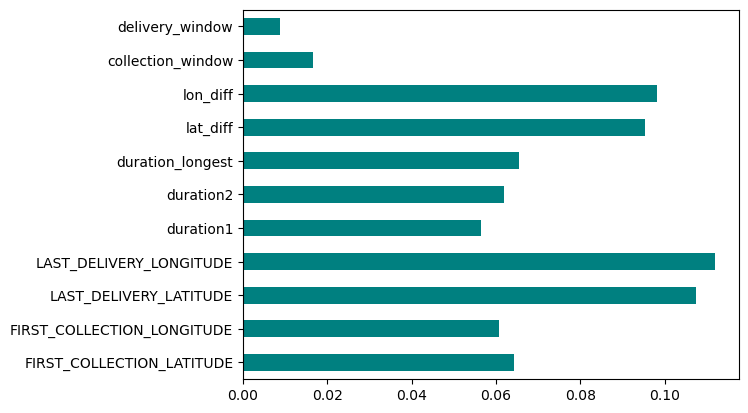

In [21]:
# Information gain calculates the reduction in entropy from the transformation of a dataset. 
# It can be used for feature selection by evaluating the Information gain of each variable in the context of the target variable

%matplotlib inline

importances = mutual_info_classif(df[num_feats], df[target])
feat_importances = pd.Series(importances, num_feats)
feat_importances.plot(kind='barh', color='teal')
plt.show()

__Findings__
* Out of the 3 durations, duration2 has the highest mutual information gain
* We will remove the other duration features to prevent multicollinearity

In [22]:
# re-define predictors & num_feats
predictors = np.setdiff1d(predictors, ['duration_longest', 'duration1'])
num_feats = np.setdiff1d(num_feats, ['duration_longest', 'duration1'])

In [23]:
df[num_feats].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3241 entries, 0 to 3240
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FIRST_COLLECTION_LATITUDE   3241 non-null   float64
 1   FIRST_COLLECTION_LONGITUDE  3241 non-null   float64
 2   LAST_DELIVERY_LATITUDE      3241 non-null   float64
 3   LAST_DELIVERY_LONGITUDE     3241 non-null   float64
 4   collection_window           3241 non-null   float64
 5   delivery_window             3241 non-null   float64
 6   duration2                   3241 non-null   float64
 7   lat_diff                    3241 non-null   float64
 8   lon_diff                    3241 non-null   float64
dtypes: float64(9)
memory usage: 228.0 KB


# 8. Modelling

## 8.1 Data Preparation for Modelling

In [24]:
random_state = 42

In [25]:
for i in ['FIRST_COLLECTION_OUTWARD_CODE', 'LAST_DELIVERY_OUTWARD_CODE']:
    df[i] = df[i].astype(str)

In [26]:
# splitting the dataset into  independent variable X and dependent(target) y
X = df[predictors]
y = df[target]

## 8.2 Define Preprocessing & Model Pipelines

In [27]:
# Create the column transformer with one-hot encoding for categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_feats),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
    ]
)

# Create the pipeline with preprocessing and logistic regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

## 8.3 Model Train and Fit, Model Selection & Model Evaluation

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

     Delayed       0.88      1.00      0.94       570
     On-Time       0.00      0.00      0.00        79

    accuracy                           0.88       649
   macro avg       0.44      0.50      0.47       649
weighted avg       0.77      0.88      0.82       649

AUC for Logistic Regression: 0.61


C:\Users\Lenovo IdeaCentre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo IdeaCentre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo IdeaCentre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for Random Forest:
              precision    recall  f1-score   support

     Delayed       0.92      0.93      0.92       570
     On-Time       0.44      0.38      0.41        79

    accuracy                           0.87       649
   macro avg       0.68      0.66      0.67       649
weighted avg       0.86      0.87      0.86       649

AUC for Random Forest: 0.78
Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

     Delayed       0.88      1.00      0.94       570
     On-Time       0.00      0.00      0.00        79

    accuracy                           0.88       649
   macro avg       0.44      0.50      0.47       649
weighted avg       0.77      0.88      0.82       649

AUC for Support Vector Machine: 0.47


C:\Users\Lenovo IdeaCentre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo IdeaCentre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo IdeaCentre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


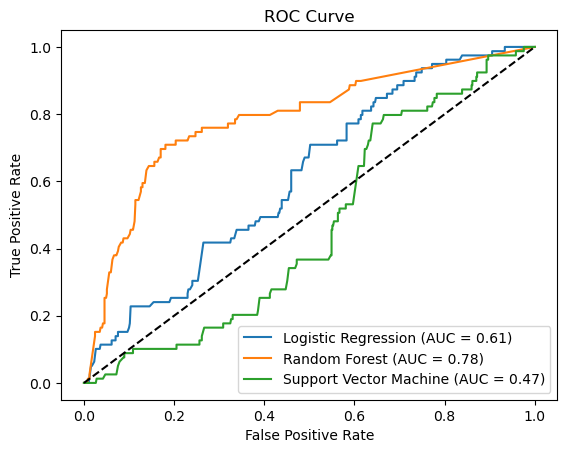

In [28]:

# Create a dictionary of models to compare
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True)  # Enable probability estimates for AUC calculation
}

best_model = None
best_auc = 0

# Train the models and evaluate their performance
for model_name, model in models.items():
    # Create the pipeline with preprocessing and the current model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=['Delayed','On-Time'])
    print(f"Classification Report for {model_name}:\n{report}")
    
    # Calculate AUC
    auc_score = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC for {model_name}: {auc_score:.2f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    
    # Keep track of the best model
    if auc_score > best_auc:
        best_auc = auc_score
        best_model = pipeline

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [29]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  array(['FIRST_COLLECTION_LATITUDE', 'FIRST_COLLECTION_LONGITUDE',
       'LAST_DELIVERY_LATITUDE', 'LAST_DELIVERY_LONGITUDE',
       'collection_window', 'delivery_window', 'duration2', 'lat_diff',
       'lon_diff'], dtype='<U26')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['VEHICLE_BUILD_UP',
                                                   'VEHICLE_SIZE',
                                                   'FIRST_COLLECTION_OUTWARD_CODE',
                                                   'LAST_DELIVERY_OUTWARD_CODE'])])),
                ('classifier', RandomForestClassifier())])

__Comments__
* Random Forest is the winning model as it has the highest AUC: 0.78
* It also scores the highest in precision & f1-score and 2nd highest on recall
* High number of False Negatives (high recall) is better than having high number of False Positives (high precision) 
* This is because it's less detrimental to shippers to falsely labelling on-time shipments than falsely labelling delayed ones

# 4. Prediction

In [30]:
df_test = df_test[X_test.columns]
df_test.columns

Index(['FIRST_COLLECTION_LATITUDE', 'FIRST_COLLECTION_LONGITUDE',
       'FIRST_COLLECTION_OUTWARD_CODE', 'LAST_DELIVERY_LATITUDE',
       'LAST_DELIVERY_LONGITUDE', 'LAST_DELIVERY_OUTWARD_CODE',
       'VEHICLE_BUILD_UP', 'VEHICLE_SIZE', 'collection_window',
       'delivery_window', 'duration2', 'lat_diff', 'lon_diff'],
      dtype='object')

In [31]:
# Predict using the trained model
unseen_predictions = best_model.predict(df_test)
unseen_predictions_prob = best_model.predict_proba(df_test)[:, 1]

# Combine predictions and their probabilities into a DataFrame
results = df_test.copy()
results['Predicted_Class'] = unseen_predictions
results['Prediction_Probability'] = unseen_predictions_prob

In [32]:
results.head()

,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,FIRST_COLLECTION_OUTWARD_CODE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,LAST_DELIVERY_OUTWARD_CODE,VEHICLE_BUILD_UP,VEHICLE_SIZE,collection_window,delivery_window,duration2,lat_diff,lon_diff,Predicted_Class,Prediction_Probability
0,53.407411,-6.238118,DUBLIN,53.537912,-1.033570,DN3,Box,Tractor Unit,18000.0,3600.0,50400.0,0.130501,5.204548,0,0.111891
1,53.882244,-1.267537,LS24,54.474078,-6.104285,BT26,Curtain-Side 13.6M Trailer,Tractor Unit,334800.0,1800.0,3600.0,0.591834,4.836748,0,0.000000
2,53.407411,-6.238118,DUBLIN,53.537912,-1.033570,DN3,Curtain-Side 13.6M Trailer,Tractor Unit,1800.0,1800.0,84600.0,0.130501,5.204548,0,0.017778
3,53.293393,-1.074008,S80,53.294121,-6.441900,DUBLIN,Curtain-Side 13.6M Trailer,Tractor Unit,3540.0,1800.0,189120.0,0.000728,5.367892,0,0.020000
4,53.293393,-1.074008,S80,54.664518,-5.932184,BT36,Curtain-Side 13.6M Trailer,Tractor Unit,3540.0,1800.0,348960.0,1.371125,4.858176,0,0.350000


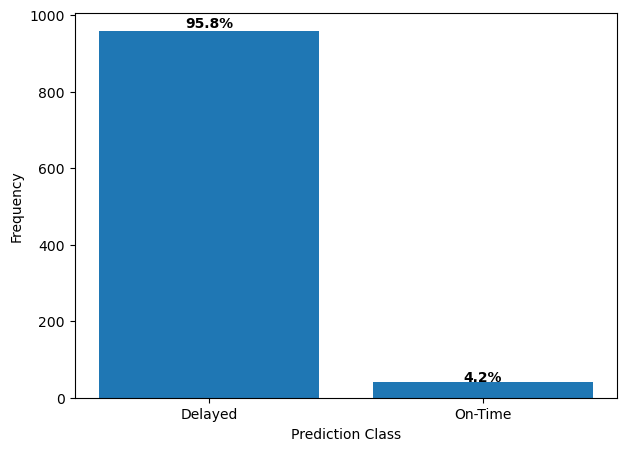

In [33]:
# # Plot prediction class distribution
helper.plot_class_distribution('Predicted_Class', results, 'Prediction Class', [0, 1], ['Delayed', 'On-Time'])

# 5. Save Results

In [34]:
results.to_csv('Data/prediction.csv')